<a href="https://colab.research.google.com/github/Siarzis/ai-tutor/blob/main/lfc_disturbance_prediction_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Data Loading & Plotting

Load and plot the training data

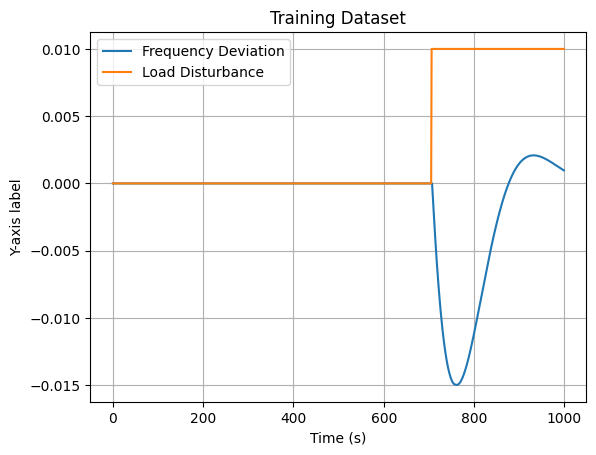

In [ ]:
train_dataset_df = pd.read_csv('train_dataset.csv', dtype=np.float32)
# print(train_dataset_df)
# train_dataset_df = train_dataset_df[train_dataset_df.index % 10 == 0]
# print(train_dataset_df)

plt.figure()
plt.plot(train_dataset_df.iloc[:1000, 1], label='Frequency Deviation')
plt.plot(train_dataset_df.iloc[:1000, 2], label='Load Disturbance')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis label')
plt.title('Training Dataset')
plt.legend()
plt.grid(True)
plt.show()

Load and plot the testing data

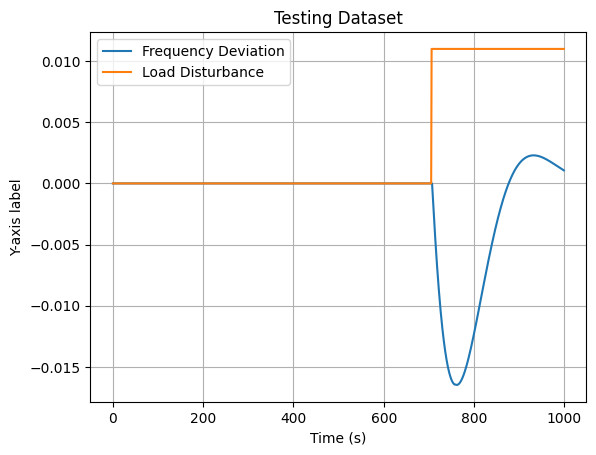

In [ ]:
test_dataset_df = pd.read_csv('test_dataset.csv', dtype=np.float32)
# test_dataset_df = test_dataset_df[test_dataset_df.index % 10 == 0]


plt.figure()
plt.plot(test_dataset_df.iloc[:1000, 1], label='Frequency Deviation')
plt.plot(test_dataset_df.iloc[:1000, 2], label='Load Disturbance')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis label')
plt.title('Testing Dataset')
plt.legend()
plt.grid(True)
plt.show()

# Data preprocess

**Pipeline description**:

csv format →  data frame → numpy → tensor

In [ ]:
def windowed_array(arr, window_size):
    # Calculate the number of subarrays
    num_windows = len(arr) - window_size

    # Create an empty array to store the result
    result = np.empty((num_windows, window_size), dtype=arr.dtype)

    # Fill the result array with windowed slices
    for i in range(num_windows):
        result[i] = arr[i:i+window_size]

    return result

class CustomDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = torch.tensor(inputs)
        self.outputs = torch.tensor(outputs)

    def __len__(self):
        return len(self.inputs)  # Assuming all arrays have the same length

    def __getitem__(self, index):
        sample = tuple((self.inputs[index], self.outputs[index]))
        return sample

In [ ]:
# for now, keep historical_window equal to prediction_window
# if not equal, the consider padding method
window = 20

# training data preprocess

X_train = train_dataset_df.iloc[:1000, 1].to_numpy()
y_train = train_dataset_df.iloc[:1000, 2].to_numpy()

X_train = windowed_array(X_train, window)
y_train = windowed_array(y_train, window)

train_tensor = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)

# testing data preprocess

X_test = test_dataset_df.iloc[:1000, 1].to_numpy()
y_test = test_dataset_df.iloc[:1000, 2].to_numpy()

X_test = windowed_array(X_test, window)
y_test = windowed_array(y_test, window)

test_tensor = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_tensor, batch_size=64, shuffle=True)

Definition & initilization of MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)

        return x

In [ ]:
# define feedforward neural network architecture
input_size = window
hidden_size_1 = 10
hidden_size_2 = 20
output_size = window

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create an instance of the neural network
net = MLP(input_size, hidden_size_1, hidden_size_2, output_size)
net = nn.DataParallel(net)
net = net.to(device)

# define loss function and optimizer
criterion = nn.MSELoss() # for classification tasks logarithmic/cross-entropy loss function is mainly used
optimizer = optim.Adam(net.parameters(), lr=0.01)

Training of MLP

In [ ]:
epochs = 500
training_loss = []

for e in range(epochs):

    total_batch_loss = 0.0
    average_batch_loss = 0.0

    # forward pass
    for i_batch, (timeseries_batch, label_batch) in enumerate(train_loader):

        timeseries_batch = timeseries_batch.to(device)
        label_batch = label_batch.to(device)

        # nullify gradients for every batch
        optimizer.zero_grad()

        output = net(timeseries_batch)

        if i_batch == 0:
            print(timeseries_batch[0])
            print(label_batch[0])
            print(output[0])

        # compute loss and store the total loss in each epoch
        loss = criterion(output, label_batch)
        total_batch_loss += loss.item()

        # backpropagation
        loss.backward() # propagate the loss backwards
        optimizer.step() # update weights

    average_batch_loss = total_batch_loss / len(train_loader)
    training_loss.append(average_batch_loss)

    print('Epoch [{}/{}], Loss: {}'.format(e+1, epochs, average_batch_loss))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([ 0.0375, -0.1035, -0.2765, -0.0301, -0.0779,  0.0755,  0.1012, -0.2390,
         0.0080, -0.1960,  0.2032, -0.0222,  0.0557, -0.2918, -0.0161, -0.0807,
        -0.0118, -0.0265,  0.0050, -0.1572], grad_fn=<SelectBackward0>)
Epoch [1/500], Loss: 0.003853423710097559
tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018,
        0.0018, 0.0017])
tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100])
tensor([ 0.0054, -0.0477,  0.0442,  0.0094, -0.0099,  0.0189,  0.0156,  0.0248,
         0.0037,  0.0050, -0.0041,  0.0003, -0.0049,  0.0699,  0.0006,  0.0024,
         0.0049, -

Plot training loss

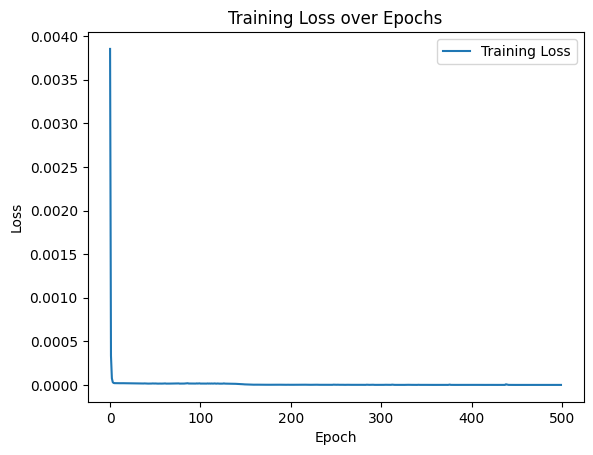

In [ ]:
# Plot the training loss
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

Model evaluation

tensor([-0.0161, -0.0161, -0.0162, -0.0163, -0.0163, -0.0164, -0.0164, -0.0164,
        -0.0164, -0.0164, -0.0165, -0.0165, -0.0165, -0.0165, -0.0165, -0.0164,
        -0.0164, -0.0164, -0.0163, -0.0163])
tensor([0.0104, 0.0103, 0.0101, 0.0096, 0.0099, 0.0095, 0.0099, 0.0104, 0.0098,
        0.0106, 0.0092, 0.0096, 0.0100, 0.0103, 0.0095, 0.0097, 0.0102, 0.0100,
        0.0099, 0.0103])


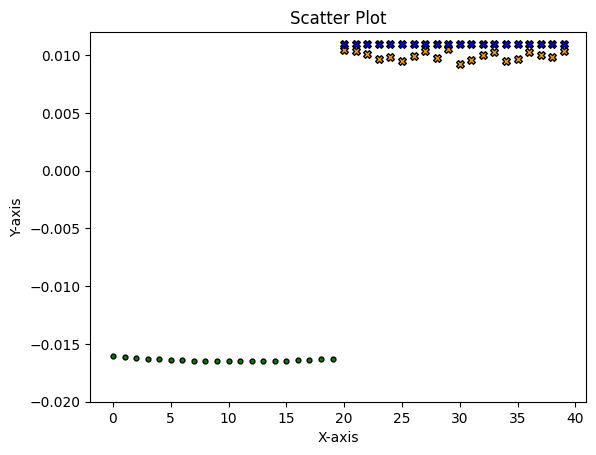

In [ ]:
for i, (test_input, test_target) in enumerate(test_tensor):
    if i == 750:
        with torch.no_grad():

            print(test_input)
            predicted = net(test_input)
            print(predicted)

            test_input = test_input.numpy()
            test_target = test_target.numpy()
            predicted = predicted.detach().numpy()

            t_max = len(test_target) + len(test_target)
            t = np.arange(0, t_max)

            # Plot dots
            plt.scatter(t[:len(test_input)], test_input, color='green', edgecolors='black', s=12)
            plt.scatter(t[len(predicted):], predicted, color='orange', marker='X', edgecolors='black', s=30)
            plt.scatter(t[len(test_target):], test_target, color='blue', marker='X', edgecolors='black', s=30)

            plt.ylim(-0.02, 0.012)

            # Set labels and title
            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            plt.title('Scatter Plot')

            # Show plot
            plt.show()

In [ ]:
num_points = 150
seq_length = 10

t = np.linspace(0, 10*np.pi, num_points)
sine_values = np.sin(t)
cosine_values = np.cos(t)



# Convert to PyTorch tensors
sine_tensor = torch.tensor(sine_values, dtype=torch.float32)
cosine_tensor = torch.tensor(cosine_values, dtype=torch.float32)

# Create sequences of sine values as input and corresponding cosine values as output
input_data = torch.stack([sine_tensor[i:i+seq_length] for i in range(num_points - seq_length)]).unsqueeze(2)
output_data = torch.stack([cosine_tensor[i+seq_length] for i in range(num_points - seq_length)]).unsqueeze(1)

print(input_data[0], output_data[0])

tensor([[0.0000],
        [0.2093],
        [0.4093],
        [0.5912],
        [0.7469],
        [0.8695],
        [0.9536],
        [0.9955],
        [0.9933],
        [0.9471]]) tensor([-0.5121])
